<a href="https://colab.research.google.com/github/DFIC-Quant-Fund/CompVision-W2024/blob/main/ImageGenerationScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


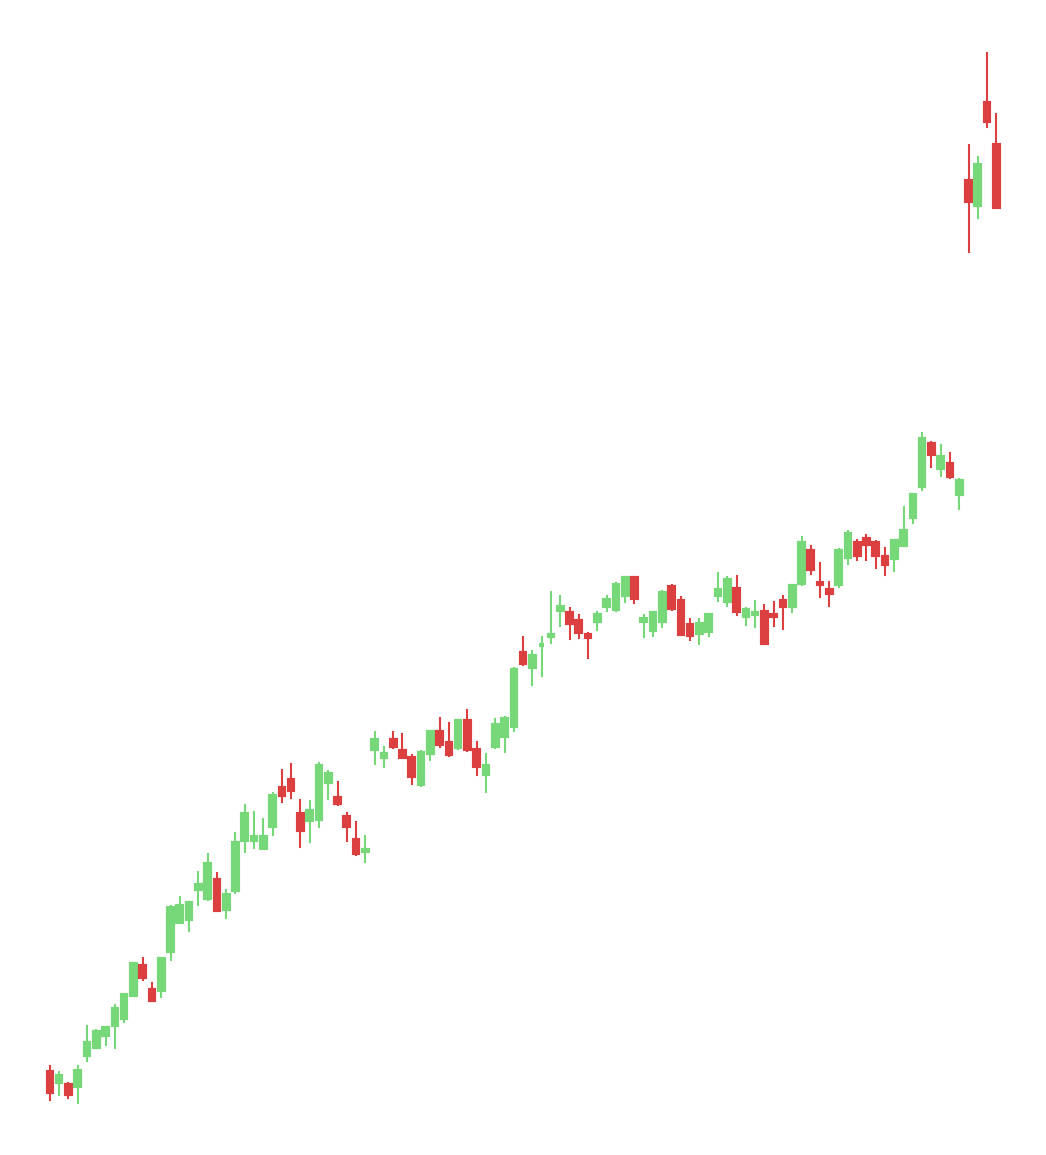

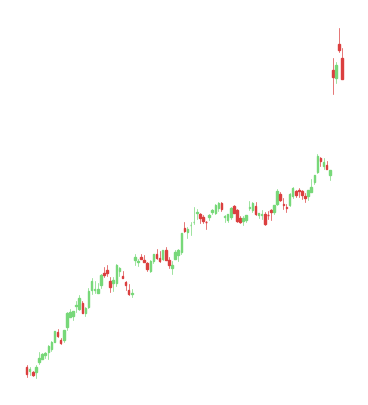

In [5]:
# Uncomment if you have not installed yet
# !pip install yfinance
# !pip install matplotlib
!pip install mplfinance
# !pip install numpy
# !pip install pillow

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from PIL import Image

stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2023-06-01'

stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
stock_data.reset_index(inplace=True)
stock_data['NumericDate'] = np.arange(len(stock_data))

ohlc = stock_data[['NumericDate', 'Open', 'High', 'Low', 'Close', 'Volume']].values

fig_width = 4.5
fig_height = 5
fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))

candlestick_ohlc(ax1, ohlc, width=0.5, colorup='#77d879', colordown='#db3f3f')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax1.axis('off')
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')

plt.savefig('chart.png', bbox_inches='tight', pad_inches=0, dpi=300)


display(Image.open("chart.png"))


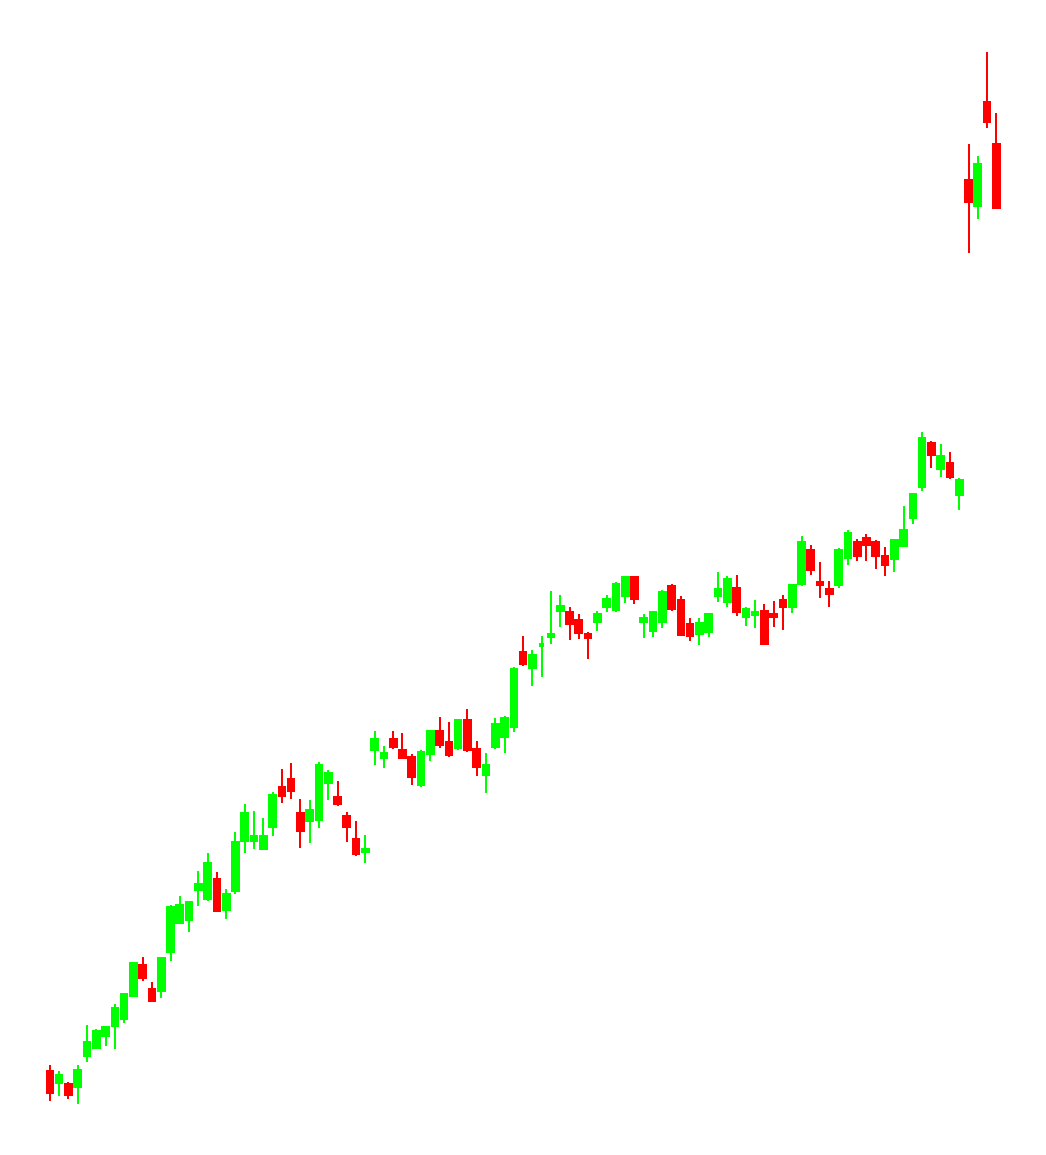

In [6]:


def round_color(pixel):
    if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
        return (255, 255, 255)
    target_colors = np.array([(255, 255, 255), (255, 0, 0), (0, 255, 0)])
    pixel_array = np.array(pixel)
    distances = np.linalg.norm(target_colors - pixel_array, axis=1)
    closest_index = np.argmin(distances)
    return tuple(target_colors[closest_index])


def convert_image(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img_data = np.array(img)
    rounded_data = np.apply_along_axis(round_color, 2, img_data)
    rounded_img = Image.fromarray(rounded_data.astype(np.uint8))
    return rounded_img

input_image_path = "chart.png"
output_image_path = "chart2.png"
rounded_image = convert_image(input_image_path)
rounded_image.save(output_image_path)

display(Image.open("chart2.png"))


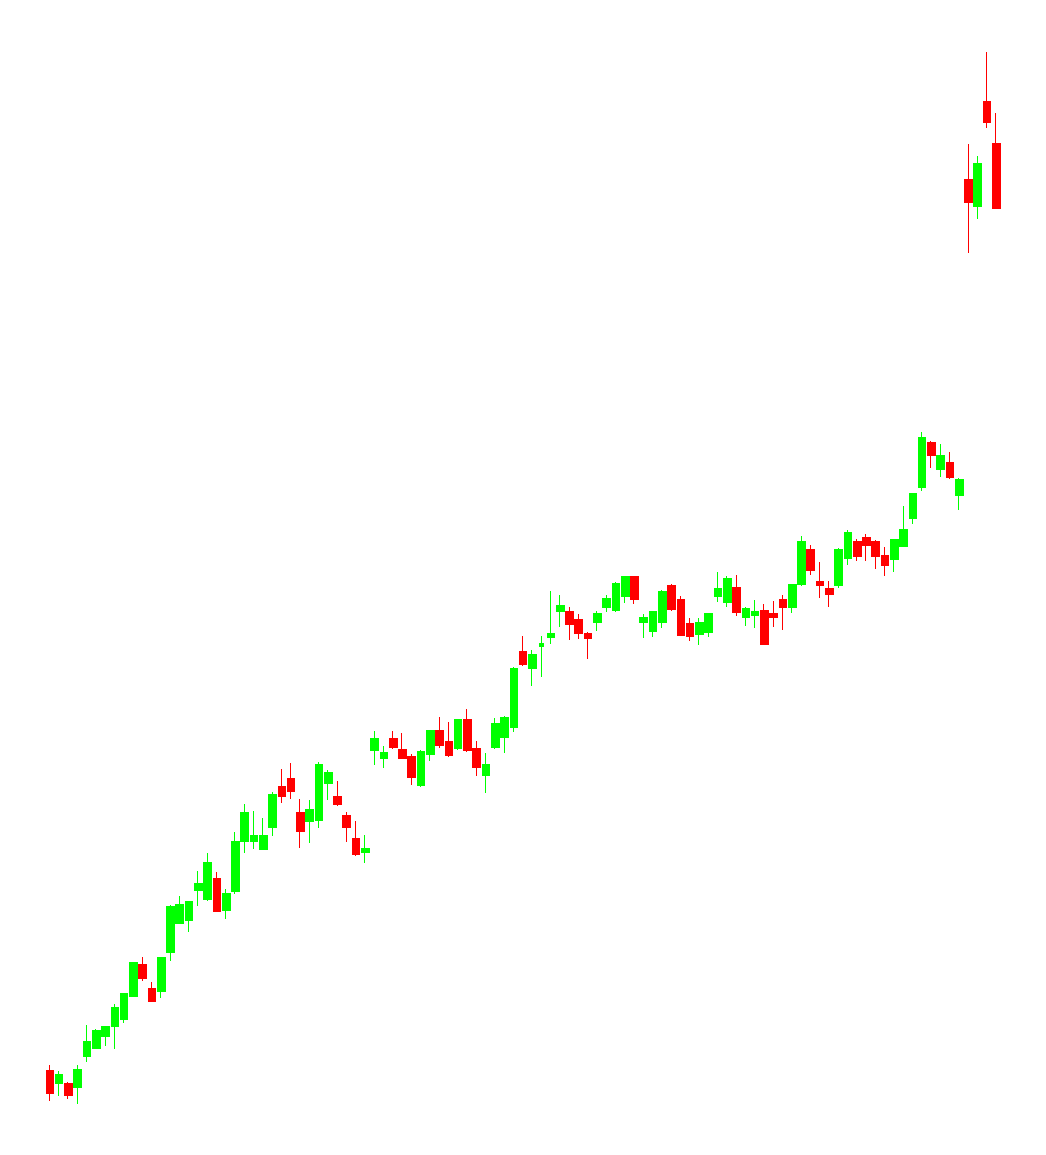

In [7]:

def png_to_hex_array(image_path):
    image = Image.open(image_path)
    image_rgba = image.convert("RGBA")
    width, height = image_rgba.size
    pixel_data = list(image_rgba.getdata())
    hex_colors = [[0 for _ in range(width)] for _ in range(height)]
    for y in range(height):
        for x in range(width):
            r, g, b, a = pixel_data[y * width + x]
            hex_colors[y][x] = '#{0:02x}{1:02x}{2:02x}{3:02x}'.format(r, g, b, a)
    return hex_colors

def hex_array_to_image(hex_colors):
    height = len(hex_colors)
    width = len(hex_colors[0])
    new_image = Image.new("RGBA", (width, height))

    for y in range(height):
        for x in range(width):
            hex_color = hex_colors[y][x]
            rgba = tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5, 7))
            new_image.putpixel((x, y), rgba)

    return new_image

def slim_high_and_low(image_path):
    to_change = []
    hex_colors = png_to_hex_array(image_path)
    main_color = ''
    stage = 0
    for i in range(len(hex_colors)):
        for j in range(len(hex_colors[0])):
            color = hex_colors[i][j]
            if stage == 0 and color == '#ffffffff':
                stage = 1
            elif stage == 1 and color != '#ffffffff':
                main_color = color
                stage = 2
            elif stage == 1 and color == '#ffffffff':
                pass
            elif stage == 2 and color == main_color:
                stage = 3
            elif stage == 2 and color == '#ffffffff':
                stage = 1
            elif stage == 3 and color == '#ffffffff':
                to_change.append((i, j-1))
                stage = 0
            else:
                stage = 0
        stage = 0
    for pair in to_change:
        i, j = pair
        hex_colors[i][j] = '#ffffffff'
    slimmed = hex_array_to_image(hex_colors)
    slimmed.save("chart3.png")


slim_high_and_low('chart2.png')

display(Image.open("chart3.png"))



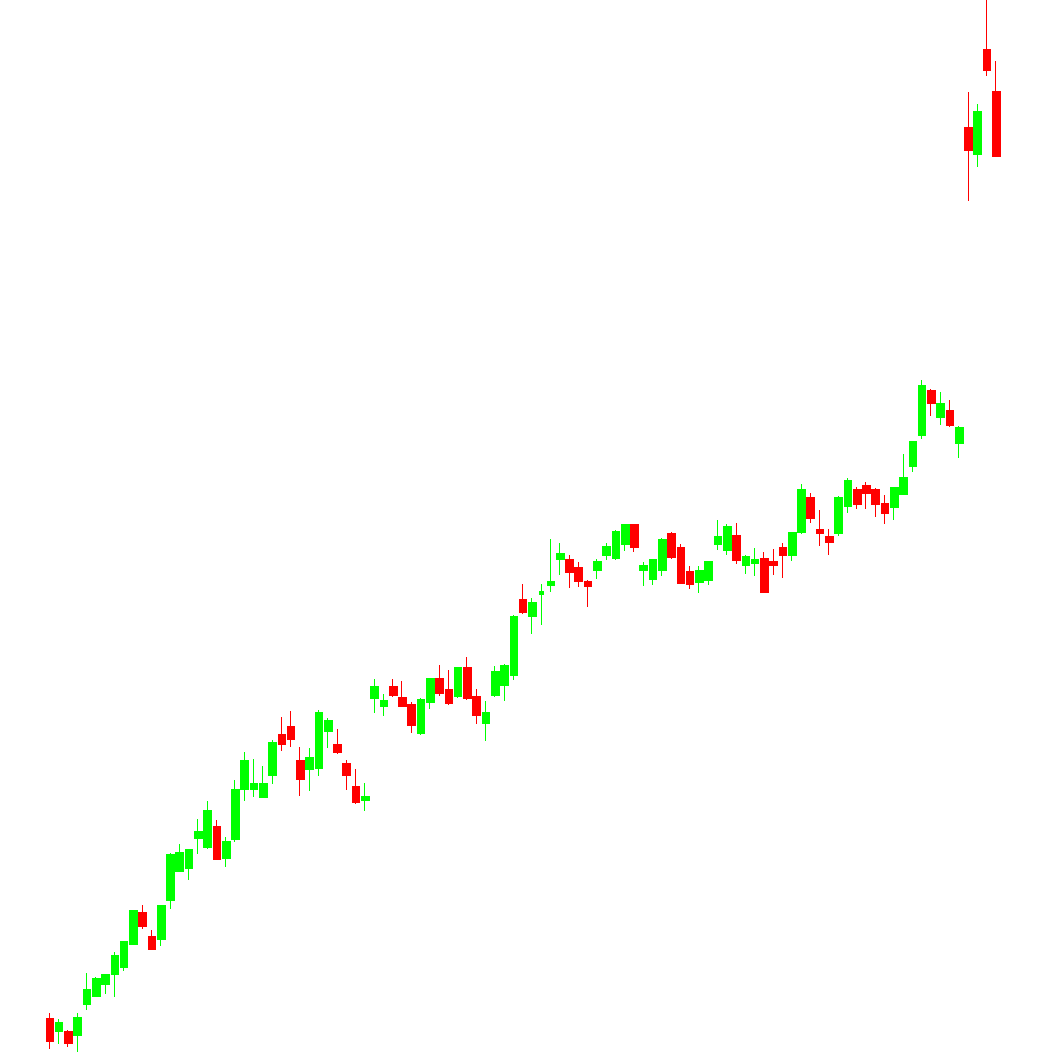

In [8]:
def png_to_hex_array(image_path):
    image = Image.open(image_path)
    image_rgba = image.convert("RGBA")
    width, height = image_rgba.size
    pixel_data = list(image_rgba.getdata())
    hex_colors = [[0 for _ in range(width)] for _ in range(height)]
    for y in range(height):
        for x in range(width):
            r, g, b, a = pixel_data[y * width + x]
            hex_colors[y][x] = '#{0:02x}{1:02x}{2:02x}{3:02x}'.format(r, g, b, a)
    return hex_colors


def crop_image_top(image_path):
    colors = png_to_hex_array(image_path)
    top_pixels = 0
    for i, row in enumerate(colors):
        only_white = True
        for color in row:
            if color != '#ffffffff':
                only_white = False
                break
        if only_white:
            top_pixels += 1
        if not only_white:
            break

    image = Image.open("chart3.png")

    width, height = image.size
    cropped_image = image.crop((0, top_pixels, width, height))
    cropped_image.save("chart4.png")

def crop_image_bottom(image_path):
    colors = png_to_hex_array(image_path)
    bottom_pixels = 0
    for i, row in enumerate(colors[::-1]):
        only_white = True
        for color in row:
            if color != '#ffffffff':
                only_white = False
                break
        if only_white:
            bottom_pixels += 1
        if not only_white:
            break

    image = Image.open("chart4.png")
    width, height = image.size
    cropped_image = image.crop((0, 0, width, height - bottom_pixels))
    cropped_image.save("chart5.png")


crop_image_top('chart3.png')
crop_image_bottom('chart4.png')



display(Image.open("chart5.png"))


# Future steps are to change size of image based on the high and low price
# make images much smaller, crop the sides of the images
# make candles 3 pixels from open to close, 1 pixel from high and low